In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [2]:
import sys
import importlib
from tqdm.notebook import tqdm, trange
import copy
import pickle

%load_ext autoreload
%autoreload 2

3844 examples loaded.


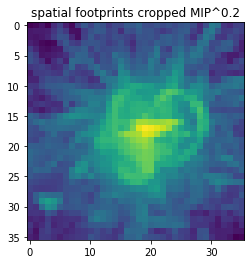

In [3]:
## TODO: avoid putting . in file names in future
## TODO: Include GPU Option

# Load modules
path_to_basic_neural_processing_modules = '/Users/josh/Documents/github_repos'
path_to_GCAMP_ROI = '/Users/josh/Documents/github_repos'
sys.path.append(path_to_basic_neural_processing_modules)
sys.path.append(path_to_GCAMP_ROI)
sys.path.append(path_to_GCAMP_ROI+'/GCaMP_ROI_classifier/new_stuff')
sys.path.append(path_to_GCAMP_ROI+'/GCaMP_ROI_classifier/End_User')
sys.path.append(path_to_GCAMP_ROI+'/GCaMP_ROI_classifier/End_User/simclr-models')

from basic_neural_processing_modules import *
from simclr_helpers import *
from util import *

# Load Data
# path_to_raw = f'./data/masks_20211202_balanced.h5' # raw data h5

# path_to_raw = f'./data/AEG9_20210914_stat.npy' # raw data npy
# path_to_y = f'./data/priya_all_rounds.npy' # raw data npy

path_to_raw = f'./data/AEG_20210913_stat.npy' # raw data npy
path_to_y = f'./data/ally_all_rounds.npy' # raw data npy

model_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=norm' # path to pth file
path_to_classifier = './classifier-models/logreg_model_0.01.pkl' # path to logististic classifier pickle file
path_to_output_file = './latent-outputs/test-run-latents.pkl' # output results file
path_to_model = './simclr-models/' + model_name + '.pth'
h5_keys = ['RHmasks', 'SYTmasks', 'NPmasks'] # list of keys within h5 to concatenate

path_to_architecture = copy.copy(model_name) # path to .py file with architecture

if path_to_raw[-3:] == '.h5':
    data = load_h5(path_to_raw, h5_keys)
elif path_to_raw[-4:] == '.npy':
#     data = torch.as_tensor(statFile_to_spatialFootprints(path_to_raw, out_height_width=[36,36], max_footprint_width=539))
    data = torch.as_tensor(statFile_to_spatialFootprints(path_to_raw, out_height_width=[36,36], max_footprint_width=725))
else:
    raise ValueError('Data type not supported!')

if path_to_raw[-4:] == '.npy':
    labels = np.load(path_to_y).astype(int)
    labels = np.where(labels==42, np.ones_like(labels)*2, labels) - 1
    labels = labels[:, -1] # Use the second to last labeling column as the one to match
else:
    raise ValueError('Response y type not supported!')

data = drop_nan_imgs(data)
print(data.shape[0], 'examples loaded.')


In [4]:
# data = data[:2048]
# data = data[:data.shape[0]//100]


In [5]:
# Instantiate Model
model_file = importlib.import_module(path_to_architecture)
model = model_file.get_model(path_to_model)
model.eval();


In [6]:
# Create Data Sets / Data Loaders
dataset, dataloader = model_file.get_dataset_dataloader(data) ## TODO: Troubleshoot the runtime on this

In [7]:
# Get Model Latents
latents = dataloader_to_latents(dataloader, model).numpy()

  0%|          | 0/31 [00:00<?, ?it/s]

In [8]:
latents2 = latents.copy()

In [9]:
# acc_train, acc_val = [], []
# # C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
# C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
# for C in C_toUse:
# #     print(f'C = {C}')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
# #     tic = time.time()
# #     logreg.fit(features_train, y_labeled_train_SYT)
#     logreg.fit(features_train, y_labeled_train)
# #     print(f'time: {time.time() - tic}')
# #     acc = logreg.score(features_train, y_labeled_train_SYT)
#     acc = logreg.score(features_train, y_labeled_train)
#     acc_train.append(acc)
# #     print(f'acc_train: {acc}')
# #     acc = logreg.score(features_val, y_labeled_val_SYT)
#     acc = logreg.score(features_val, y_labeled_val)
#     acc_val.append(acc)
# #     print(f'acc_val: {acc}')
# #     print('')
    

# plt.figure()
# plt.plot(C_toUse, acc_train)
# plt.plot(C_toUse, acc_val)
# plt.xscale('log')
# plt.xlabel('C')
# plt.ylabel('acc')
# plt.legend(['train', 'test']);

In [10]:
features_train = latents.copy()
y_labeled_train = labels.copy()

In [11]:
raw_filename = path_to_raw.split('/')[-1].split('.')[0]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

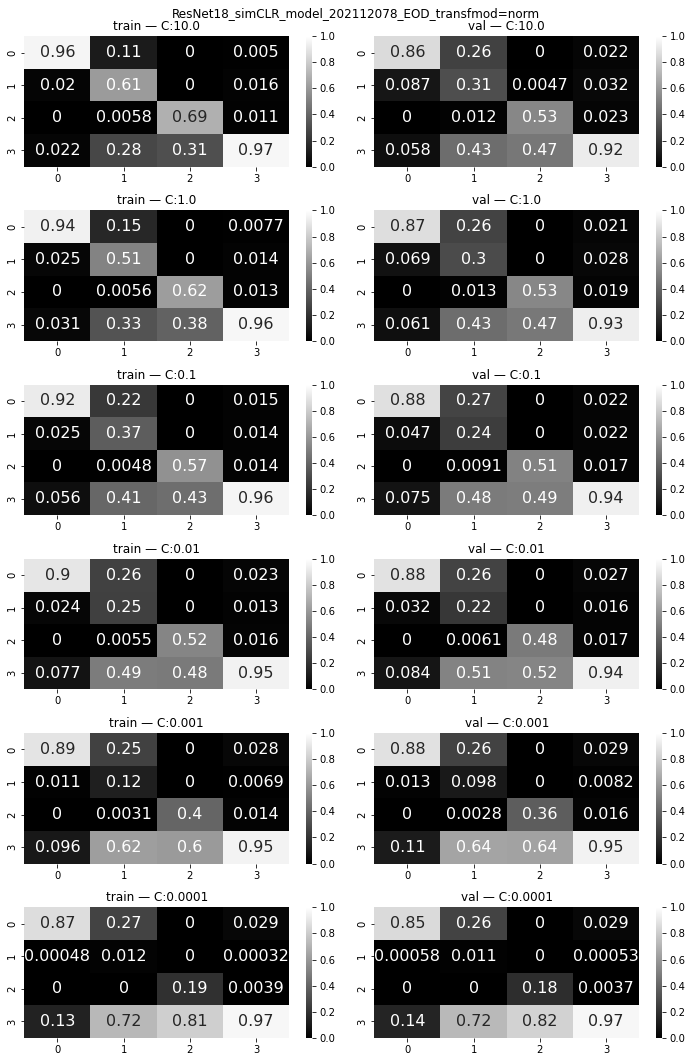

In [15]:
import seaborn as sns
import sklearn.linear_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit

acc_lst = []

splitter = ShuffleSplit(n_splits=50)
all_split_inx = list(splitter.split(features_train))

train_X = [features_train[_[0]] for _ in all_split_inx]
train_y = [y_labeled_train[_[0]] for _ in all_split_inx]
# train_y = [y_labeled_train_SYT[_[0]] for _ in all_split_inx]
test_X = [features_train[_[1]] for _ in all_split_inx]
test_y = [y_labeled_train[_[1]] for _ in all_split_inx]
# test_y = [y_labeled_train_SYT[_[1]] for _ in all_split_inx]

%matplotlib inline

c_lst = [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]

fig, ax = plt.subplots(len(c_lst), 2, figsize=(10,15))
plt.suptitle(f'{model_name}')

for ic, c in enumerate(c_lst):
    train_cms = []
    test_cms = []
    
    acc = []
    
    for inx_split in trange(len(train_X)):
        tmp_train_X = train_X[inx_split]
        tmp_train_y = train_y[inx_split]
        
        tmp_test_X = test_X[inx_split]
        tmp_test_y = test_y[inx_split]
        
        logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=3000, C=c).fit(tmp_train_X, tmp_train_y)
        
        proba = logreg.predict_proba(tmp_train_X)

        preds = np.argmax(proba, axis=1)
        cm = classification.confusion_matrix(preds, tmp_train_y)
#         cm = confusion_matrix(preds, tmp_train_y)
#         cm = cm/cm.sum(axis=0, keepdims=True)
        train_cms.append(cm)
        
#         print(train_cms[-1])
        
        proba = logreg.predict_proba(tmp_test_X)
        preds = np.argmax(proba, axis=1)
        cm = classification.confusion_matrix(preds, tmp_test_y)
#         cm = confusion_matrix(preds, tmp_test_y).T
#         cm = cm/cm.sum(axis=0, keepdims=True)
        test_cms.append(cm)
        
#         print(test_cms[-1])
#         print()
# #         acc.append(logreg.score(tmp_test_X, tmp_test_y))
    
#     acc_lst.append(np.mean(acc))
    
    
    
    
    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=3000, C=c).fit(features_train, y_labeled_train)
    lm_fn = '-'.join(['logreg_model', f"model={model_name}", f"raw_filename={raw_filename}", f"c={c}"]) + '.pkl'
    with open('./classifier-models/' + lm_fn, 'wb') as lm_f:
        pickle.dump(logreg, lm_f)
    
    
    
    
    
    sns.heatmap(np.mean(train_cms,axis=0), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[ic, 0])
    ax[ic, 0].set_title(f'train — C:{c}');

    sns.heatmap(np.mean(test_cms,axis=0), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[ic, 1])
    ax[ic, 1].set_title(f'val — C:{c}');

plt.tight_layout()


In [16]:
lm_fn

'logreg_model-model=ResNet18_simCLR_model_202112078_EOD_transfmod=norm-raw_filename=AEG_20210913_stat-c=0.0001.pkl'

In [14]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# Load Logistic Model
classifier_model = load_classifier_model(path_to_classifier)

In [ ]:
# Predict ROIs — Save to File
preds = classifier_model.predict_proba(latents)
ret = get_returns(latents, classifier_model, path_to_model, path_to_classifier)
pickle_helpers.simple_save(ret, path_to_output_file)
